In [36]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.spatial import ConvexHull, Delaunay
import pickle




In [37]:
exemplar_df = pd.read_csv('/Users/swarchol/Research/exemplar-001/new/updated.csv')
greg_df = pd.read_csv('/Users/swarchol/Research/bed/data/updated_renamed.csv')

# # read results.pkl
# with open('/Users/swarchol/Research/bed/data/results.pkl', 'rb') as f:
#     results_dict = pickle.load(f)
# results_dict

In [38]:
def calculate_concave_hull(coordinates, length_threshold=50):
    """
    Calculate the concave hull of the given coordinates.

    Parameters:
    coordinates (np.ndarray): Array of shape (n_samples, n_features) containing the coordinates.
    length_threshold (float): Length threshold for the concave hull algorithm.

    Returns:
    np.ndarray: The concave hull points.
    """
    hull_vertices = ConvexHull(coordinates)
    # rreturn the points
    # return area
    return coordinates[hull_vertices.vertices], hull_vertices.volume


def process_coordinates(spatial_coords, embedding_coords, k=100, length_threshold=50):
    """
    Process spatial and embedding coordinates to calculate mean distances and concave hulls.

    Parameters:
    spatial_coords (np.ndarray): Array of shape (n_samples, 2) containing the spatial coordinates.
    embedding_coords (np.ndarray): Array of shape (n_samples, 2) containing the embedding coordinates.
    k (int): Number of nearest neighbors to consider.
    threshold (float): Distance threshold to decide whether to calculate the concave hull.
    length_threshold (float): Length threshold for the concave hull algorithm.

    Returns:
    dict: Dictionary containing the results for spatial and embedding coordinates.
    """
    results = {}

    # Process spatial coordinates
    concave_hull_spatial, spatial_volume = calculate_concave_hull(
        spatial_coords, length_threshold
    )
    results["spatial"] = {
        "concave_hull": concave_hull_spatial.tolist(),
        "volume": spatial_volume,
        "density": len(spatial_coords) / spatial_volume,
        "centroid": np.mean(spatial_coords, axis=0).tolist(),
    }
    concave_hull_embedding, embedding_volume = calculate_concave_hull(
        embedding_coords, length_threshold
    )
    results["embedding"] = {
        "concave_hull": concave_hull_embedding.tolist(),
        "volume": embedding_volume,
        "density": len(embedding_coords) / embedding_volume,
        "centroid": np.mean(embedding_coords, axis=0).tolist(),
    }
    return results



In [41]:
greg_df

,CellID,DNA,DNA (2),DNA (3),CD3,CD45RO,DNA (4),Pan-cytokeratin,Aortic smooth muscle actin,DNA (5),...,Orientation,Sample,Condition,Replicate,emb1,emb2,cluster_2d,UMAP_X,UMAP_Y,kmeans
0,47,15160.563636,46937.436364,42258.036364,0.235838,0.446541,24461.163636,0.270726,0.175902,29225.363636,...,-1.345788,WD-76845-097,CRC,1,8.872235,19.100700,-1,16034.611561,20497.943539,3
1,49,11740.781250,50723.343750,37632.750000,0.227137,0.584889,20075.703125,0.307917,0.174437,23681.062500,...,-1.338040,WD-76845-097,CRC,1,8.379912,20.137026,48,15764.366949,21180.248327,3
2,51,9565.513514,35690.567568,27032.162162,0.200757,0.436587,14392.621622,0.223040,0.162788,16623.810811,...,-1.475095,WD-76845-097,CRC,1,8.799885,19.362713,-1,15994.897394,20670.449801,3
3,52,7308.113636,24641.750000,19214.886364,0.228204,0.662923,9205.522727,0.272994,0.207245,11968.636364,...,-1.390750,WD-76845-097,CRC,1,8.504932,20.219538,48,15832.992590,21234.573253,3
4,53,19249.623188,57667.202899,53509.811594,0.261224,0.704192,30691.275362,0.295741,0.296045,35399.927536,...,-1.441929,WD-76845-097,CRC,1,8.576233,20.350970,48,15872.130942,21321.106528,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933248,1242746,18694.276596,18604.936170,17079.659574,0.248739,0.205520,6982.680851,0.136490,0.334573,9554.489362,...,-0.935988,WD-76845-097,CRC,1,18.186203,2.827556,72,21147.209738,9783.897947,2
933249,1242748,31240.095238,34545.301587,32678.349206,0.361773,0.381520,12513.238095,0.219673,0.126889,17597.158730,...,0.459917,WD-76845-097,CRC,1,11.654654,19.720820,-1,17561.929764,20906.223217,3
933250,1242751,45004.015873,47513.269841,44139.714286,0.229271,0.467404,16901.253968,0.152905,0.283555,20190.285714,...,0.830085,WD-76845-097,CRC,1,18.262630,3.071928,72,21189.161841,9944.789517,11
933251,1242753,33568.983607,35640.344262,31911.131148,0.233328,0.515689,12369.524590,0.134693,0.331565,15530.245902,...,-1.363981,WD-76845-097,CRC,1,19.307392,3.061911,72,21762.649778,9938.194640,2


In [45]:
results_dict = {}
for csv_df, name, cluster_cols in [
    (greg_df, "greg", ["kmeans", "cluster_2d"]),
    (exemplar_df, "exemplar", ["kmeans", "agcluster"]),
]:
    results_dict[name] = {}
    all_features = [
        "ELANE",
        "CD57",
        "CD45",
        "CD11B",
        "SMA",
        "CD16",
        "ECAD",
        "FOXP3",
        "NCAM",
        "anti_CD3",
        "anti_CD45RO",
        "Keratin_570",
        "aSMA_660",
        "CD4_488",
        "CD45_PE",
        "PD1_647",
        "CD20_488",
        "CD68_555",
        "CD8a_660",
        "CD163_488",
        "FOXP3_570",
        "PDL1_647",
        "Ecad_488",
        "Vimentin_555",
        "CDX2_647",
        "LaminABC_488",
        "Desmin_555",
        "CD31_647",
        "PCNA_488",
        "CollagenIV_647",
        "CD3",
        "CD45RO",
        "Pan-cytokeratin",
        "Aortic smooth muscle actin",
        "CD4",
        "CD45",
        "PD-1",
        "CD20",
        "CD68",
        "CD8a",
        "CD163",
        "FOXP3",
        "PD-L1",
        "E-cadherin",
        "Vimentin",
        "CDX-2",
        "Lamin-A/B/C",
        "Desmin",
        "CD31",
        "PCNA",
        "Collagen",
    ]
    all_features = list(set(all_features))
    # Check which of the potential features are in the csv_df
    potential_features = [
        feature for feature in all_features if feature in csv_df.columns
    ]
    sel_df = csv_df.drop(
        [
            "Area",
            "MajorAxisLength",
            "MinorAxisLength",
            "Eccentricity",
            "Solidity",
            "Extent",
            "Orientation",
            "DNA_1",
            "DNA_2",
            "DNA_3",
            "DNA_4",
            "DNA_5",
            "DNA_6",
            "DNA_7",
            "DNA_8",
            "DNA_9",
            "DNA_10",
            "DNA_11",
            "DNA_12",
            "DNA_13",
        ],
        axis=1,
        errors="ignore",
    )

    x_df = sel_df[potential_features]
    feature_names = x_df.columns
    
    print(cluster_cols)
    for col in cluster_cols:
        
        if col in sel_df.columns:
            y_df = sel_df[col]
            results_dict[name][col] = {}
        else:
            print(f"Cluster column {col} not found in the dataframe.")
        cluster_names = y_df.unique()
        print(f"Processing {name} {col}")
        label_encoder = LabelEncoder()
        y_df = label_encoder.fit_transform(y_df)
        x_train, x_test, y_train, y_test = train_test_split(
            x_df, y_df, test_size=0.2, random_state=42
        )
        model = xgb.XGBClassifier(
            objective="multi:softmax", num_class=len(np.unique(y_train))
        )
        model.fit(x_train, y_train)
        explainer = shap.Explainer(model)
        shap_values = explainer(x_test)
        y_pred = model.predict(x_test)

        # Classification Report
        print(f"Classification Report for {name} {col}")
        print(classification_report(y_test, y_pred))
        for i, cluster in enumerate(cluster_names):
            cluster_name = str(cluster)
            print(f"Processing {name} {col} {cluster}")
            avg_shap = shap_values.values[:, :, i].mean(0)
            results_dict[name][col][cluster_name] = {}
            results_dict[name][col][cluster_name]["shap_values"] = avg_shap.tolist()
            results_dict[name][col][cluster_name]["shap_importance"] = (
                np.abs(avg_shap).mean().item()
            )
            feat_imp = list(zip(feature_names, avg_shap.tolist()))
            results_dict[name][col][cluster_name]["feat_imp"] = feat_imp
            cluster_df = sel_df[sel_df[col] == cluster]
            cell_ids = cluster_df["CellID"].values
            results_dict[name][col][cluster_name]["cell_ids"] = cell_ids.tolist()
            results_dict[name][col][cluster_name]["coordinates"] = {}
            embedding_coordinates = cluster_df[["UMAP_X", "UMAP_Y"]].values
            spatial_coordinates = cluster_df[["X_centroid", "Y_centroid"]].values
            results = process_coordinates(spatial_coordinates, embedding_coordinates)
            results_dict[name][col][cluster_name]["hulls"] = results




['kmeans', 'cluster_2d']
Processing greg kmeans
Classification Report for greg kmeans
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24391
           1       0.86      0.86      0.86      8159
           2       0.95      0.95      0.95     12892
           3       0.95      0.94      0.95     12138
           4       0.91      0.90      0.91     15869
           5       0.92      0.91      0.92     10904
           6       0.91      0.91      0.91     17213
           7       0.96      0.97      0.97     15733
           8       0.95      0.94      0.95      4143
           9       0.90      0.88      0.89     14487
          10       0.95      0.96      0.95     12482
          11       0.89      0.90      0.90     17342
          12       0.92      0.91      0.92     20898

    accuracy                           0.92    186651
   macro avg       0.92      0.92      0.92    186651
weighted avg       0.92      0.92      0.92    1

In [47]:
# write results dict to pickle /Users/swarchol/Research/bed/data/results.pkl, overwriting
with open("/Users/swarchol/Research/bed/data/results.pkl", 'wb') as f:
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [44]:
sel_df[sel_df[col] == int(cluster)]


,CellID,DNA,DNA (2),DNA (3),CD3,CD45RO,DNA (4),Pan-cytokeratin,Aortic smooth muscle actin,DNA (5),...,Y_centroid,Sample,Condition,Replicate,emb1,emb2,cluster_2d,UMAP_X,UMAP_Y,kmeans
0,47,15160.563636,46937.436364,42258.036364,0.235838,0.446541,24461.163636,0.270726,0.175902,29225.363636,...,1228.290909,WD-76845-097,CRC,1,8.872235,19.100700,-1,16034.611561,20497.943539,3
1,49,11740.781250,50723.343750,37632.750000,0.227137,0.584889,20075.703125,0.307917,0.174437,23681.062500,...,1233.937500,WD-76845-097,CRC,1,8.379912,20.137026,48,15764.366949,21180.248327,3
2,51,9565.513514,35690.567568,27032.162162,0.200757,0.436587,14392.621622,0.223040,0.162788,16623.810811,...,1235.189189,WD-76845-097,CRC,1,8.799885,19.362713,-1,15994.897394,20670.449801,3
3,52,7308.113636,24641.750000,19214.886364,0.228204,0.662923,9205.522727,0.272994,0.207245,11968.636364,...,1234.886364,WD-76845-097,CRC,1,8.504932,20.219538,48,15832.992590,21234.573253,3
4,53,19249.623188,57667.202899,53509.811594,0.261224,0.704192,30691.275362,0.295741,0.296045,35399.927536,...,1239.521739,WD-76845-097,CRC,1,8.576233,20.350970,48,15872.130942,21321.106528,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933242,1242739,48477.266667,52766.200000,50098.533333,0.187645,0.345090,17917.866667,0.160032,0.281813,23280.466667,...,26813.300000,WD-76845-097,CRC,1,11.465922,18.851616,50,17458.331229,20333.949577,3
933244,1242742,45453.513761,47233.926606,45217.431193,0.204101,0.660908,19106.532110,0.281000,0.201656,22669.146789,...,26813.733945,WD-76845-097,CRC,1,7.873138,18.963196,41,15486.189932,20407.412530,3
933245,1242743,50322.591837,53202.551020,50443.734694,0.269183,0.520972,22388.408163,0.149828,0.162682,28684.714286,...,26812.673469,WD-76845-097,CRC,1,11.642731,19.782896,-1,17555.384748,20947.093321,3
933246,1242744,46123.612245,49944.204082,50206.795918,0.266943,0.469537,20286.816327,0.182806,0.158855,24284.571429,...,26814.000000,WD-76845-097,CRC,1,11.684489,18.734224,50,17578.306437,20256.660072,3


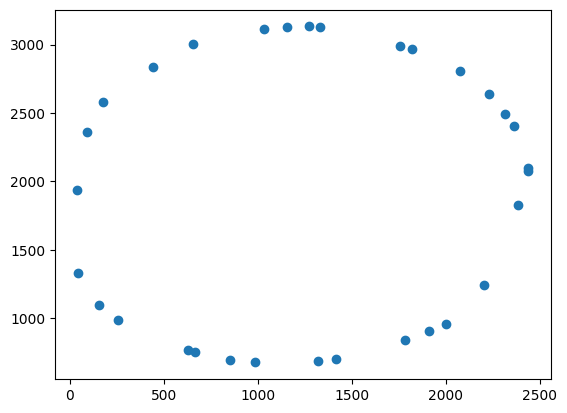

In [33]:
# test coords
test_coords = results_dict['exemplar']['kmeans']['Kluster 4']['hulls']['spatial']['concave_hull']
test_coords = np.array(test_coords)
plt.scatter(test_coords[:, 0], test_coords[:, 1])

In [34]:
# 1000 random ints in range exemplar_df shape with no duplicates
selection_ids = np.random.randint(0, exemplar_df.shape[0], 1000)
selection_ids = np.unique(selection_ids)

Fitting model
Model Fit


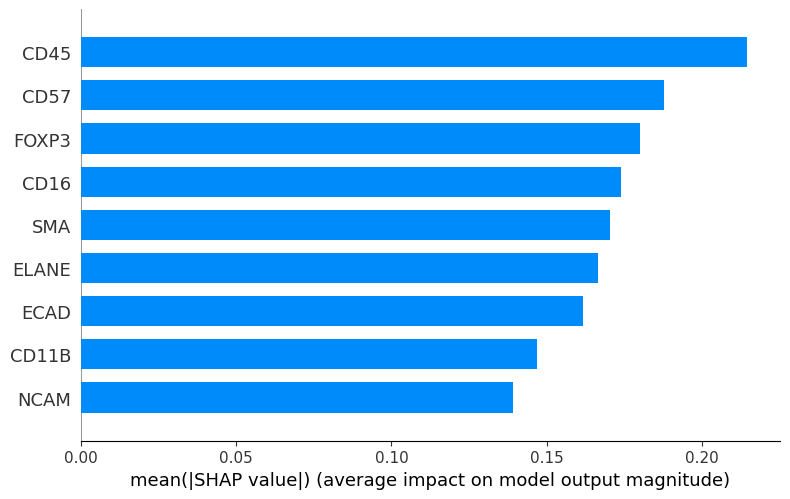

In [35]:
all_features = [
    "ELANE",
    "CD57",
    "CD45",
    "CD11B",
    "SMA",
    "CD16",
    "ECAD",
    "FOXP3",
    "NCAM",
    "anti_CD3",
    "anti_CD45RO",
    "Keratin_570",
    "aSMA_660",
    "CD4_488",
    "CD45_PE",
    "PD1_647",
    "CD20_488",
    "CD68_555",
    "CD8a_660",
    "CD163_488",
    "FOXP3_570",
    "PDL1_647",
    "Ecad_488",
    "Vimentin_555",
    "CDX2_647",
    "LaminABC_488",
    "Desmin_555",
    "CD31_647",
    "PCNA_488",
    "CollagenIV_647",
    "CD3",
    "CD45RO",
    "Pan-cytokeratin",
    "Aortic smooth muscle actin",
    "CD4",
    "CD45",
    "PD-1",
    "CD20",
    "CD68",
    "CD8a",
    "CD163",
    "FOXP3",
    "PD-L1",
    "E-cadherin",
    "Vimentin",
    "CDX-2",
    "Lamin-A/B/C",
    "Desmin",
    "CD31",
    "PCNA",
    "Collagen",
]
csv_df = exemplar_df
all_features = list(set(all_features))
# Check which of the potential features are in the csv_df
potential_features = [
    feature for feature in all_features if feature in csv_df.columns
]
sel_df = csv_df.drop(
    [
        "Area",
        "MajorAxisLength",
        "MinorAxisLength",
        "Eccentricity",
        "Solidity",
        "Extent",
        "Orientation",
        "DNA_1",
        "DNA_2",
        "DNA_3",
        "DNA_4",
        "DNA_5",
        "DNA_6",
        "DNA_7",
        "DNA_8",
        "DNA_9",
        "DNA_10",
        "DNA_11",
        "DNA_12",
        "DNA_13",
    ],
    axis=1,
    errors="ignore",
)
# sel_df[potential_features] = np.log1p(sel_df[potential_features])
sel_df["in_selection"] = 0
# CellID in selection_ids
sel_df.loc[sel_df["CellID"].isin(selection_ids), "in_selection"] = 1
# sel_df.drop("CellID", axis=1, inplace=True)
# potential feature columns

x_df = sel_df[potential_features]

y_df = sel_df[["in_selection"]]
feature_names = x_df.columns
model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=len(np.unique(y_df))
)
print("Fitting model")
# Update to fit on a random subset of the data
random_subset = np.random.choice(x_df.shape[0], 5000, replace=False)
x_subset_values = x_df.values[random_subset]
y_subset_values = y_df.values[random_subset]
x_train, x_test, y_train, y_test = train_test_split(
    x_subset_values, y_subset_values, test_size=0.2, random_state=42
)

model.fit(x_train, y_train)
print("Model Fit")

explainer = shap.Explainer(model)
shap_values = explainer(x_test)
# plot as bar
shap.summary_plot(shap_values[:,:,0], x_test, feature_names=feature_names, plot_type='bar')


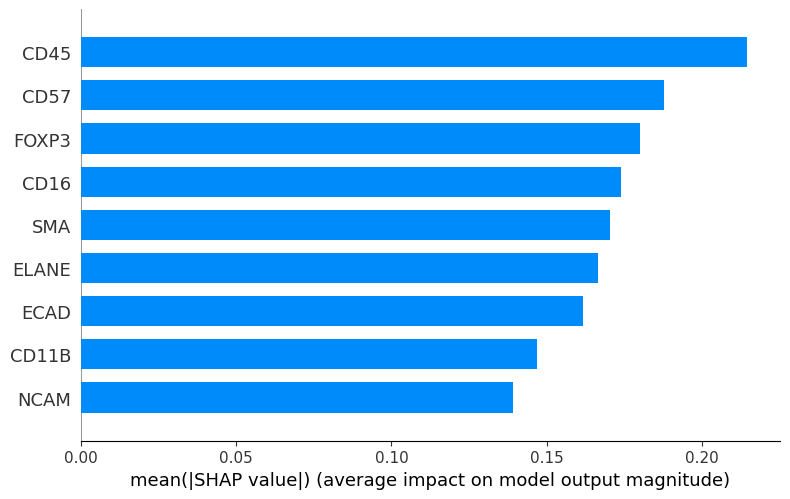

In [36]:
shap.summary_plot(shap_values[:,:,1], x_test, feature_names=feature_names,plot_type='bar')

In [37]:
avg_shap = shap_values.values[:, :, 0].mean(0)
avg_shap

array([0.08811785, 0.09855387, 0.0789433 , 0.08958175, 0.09434026,
       0.0577281 , 0.0411043 , 0.06910843, 0.05089315], dtype=float32)

In [38]:
avg_shap = shap_values.values[:, :, 1].mean(0)
avg_shap

array([-0.08811783, -0.09855387, -0.07894331, -0.08958177, -0.09434026,
       -0.0577281 , -0.04110431, -0.06910843, -0.05089313], dtype=float32)

In [1]:
avg_shap


NameError: name 'avg_shap' is not defined

In [8]:
exemplar_df['CellID'], greg_df['CellID']


(0            1
 1            2
 2            3
 3            4
 4            5
          ...  
 11165    11166
 11166    11167
 11167    11168
 11168    11169
 11169    11170
 Name: CellID, Length: 11170, dtype: int64,
 0              47
 1              49
 2              51
 3              52
 4              53
            ...   
 933248    1242746
 933249    1242748
 933250    1242751
 933251    1242753
 933252    1242755
 Name: CellID, Length: 933253, dtype: int64)

In [6]:
greg_df['X_centroid'], exemplar_df['Y_centroid']

0         9421.436364
1         9460.328125
2         9475.702703
3         9507.795455
4         9513.478261
             ...     
933248    7316.808511
933249    7084.936508
933250    6961.650794
933251    6942.491803
933252    6925.416667
Name: X_centroid, Length: 933253, dtype: float64

In [46]:
# read results.pkl
with open('/Users/swarchol/Research/bed/data/results.pkl', 'rb') as f:
    results_dict = pickle.load(f)
results_dict

FileNotFoundError: [Errno 2] No such file or directory: '/Users/swarchol/Research/bed/data/results.pkl'

In [49]:
results_dict['greg']['kmeans'].keys()

dict_keys(['3', '11', '1', '2', '4', '10', '7', '5', '12', '6', '9', '8', '0'])

In [48]:
results_dict

{'greg': {'kmeans': {'3': {'shap_values': [-0.5199246406555176,
     -0.4336872398853302,
     -0.2035161405801773,
     -0.020458536222577095,
     -0.015075953677296638,
     -0.31291133165359497,
     -0.2464461773633957,
     -0.047761641442775726,
     -0.16095677018165588,
     -0.12815508246421814,
     -0.11869345605373383,
     -0.7257307767868042,
     -1.1279544830322266,
     -0.0272552240639925,
     -0.3537774085998535,
     -0.11310441792011261,
     -0.008366028778254986,
     -0.121747687458992,
     -1.5731099843978882,
     0.001831991015933454,
     -0.02994907833635807],
    'shap_importance': 0.2995435297489166,
    'feat_imp': [('Aortic smooth muscle actin', -0.5199246406555176),
     ('CD45', -0.4336872398853302),
     ('CD68', -0.2035161405801773),
     ('Desmin', -0.020458536222577095),
     ('FOXP3', -0.015075953677296638),
     ('E-cadherin', -0.31291133165359497),
     ('Vimentin', -0.2464461773633957),
     ('CD31', -0.047761641442775726),
     ('CD8a', -0